In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import glob

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader,TensorDataset


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
print(device)
print(torch.cuda.get_device_name(0))
print(torch.cuda.memory_summary())

cuda
NVIDIA GeForce RTX 4070 Laptop GPU
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool 

In [4]:
df = pd.read_csv("dataset/merged_data.csv")
df

,Breeding line,population,S1A_1158055,S1A_1238021,S1A_3452684,S1A_3469197,S1A_3793383,S1A_3978918,S1A_3978937,S1A_4159194,...,SUN_456673396,SUN_458088855,SUN_458680476,SUN_458680508,SUN_464606444,SUN_472782494,SUN_475092207,SUN_475092311,SUN_475287011,Yield
0,MASBC10038S_1001U,LND17_F5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,1,0,3.261735
1,MASBC10056S_3001,LND17_F5,0,0,0,0,0,0,0,0,...,1,0,2,2,0,1,0,2,2,3.706517
2,MASBC10056S_3003,LND17_F5,2,2,2,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,4.966733
3,MASBC10056S_3004U,LND17_F5,0,0,0,0,0,2,0,2,...,0,0,0,0,0,0,0,2,2,3.780648
4,MASBC10056S_3005,LND17_F5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,2,1,2.594562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1763,SWW14498DH840,PUL18_DH,0,0,0,2,2,2,2,2,...,2,2,0,0,2,2,0,0,2,9.118033
1764,SWW14498DH860,PUL18_DH,0,0,0,2,2,2,2,2,...,2,2,0,0,2,2,0,0,2,6.523471
1765,SWW14498DH870,PUL18_DH,0,0,0,2,2,2,2,2,...,2,2,0,0,2,2,0,0,2,7.042383
1766,SWW14498DH880,PUL18_DH,0,0,0,2,2,2,2,2,...,2,2,0,0,2,2,0,0,2,8.747381


In [5]:
print(f"max_value: {df['Yield'].max()}")
print(f"min_value: {df['Yield'].min()}")

max_value: 13.4175929
min_value: 0.269


In [6]:
def get_SNP(path):   
    df = pd.read_csv(f"dataset/{path}")
    df = df.drop(["Breeding line", "population"],axis=1) # All SNP columns
    X = df.drop(["Yield"],axis=1)
    y = df['Yield']  # Convert phenotype to float
    
    X_var_filtered = np.array(X)
    y = np.array(y)

    # Train-Test split (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(
        X_var_filtered, y, test_size=0.2)

    # Further split train into train/val (80/20 split of the train set)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2)
    
    input_dim = X_train.shape[1]

    class SNPPhenotypeDataset(Dataset):
        def __init__(self, X, y):
            self.X = torch.tensor(X, dtype=torch.float32)  
            self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)  

        def __len__(self):
            return len(self.X)

        def __getitem__(self, idx):
            return self.X[idx].unsqueeze(0), self.y[idx]
        
    train_dataset = SNPPhenotypeDataset(X_train, y_train)
    val_dataset   = SNPPhenotypeDataset(X_val, y_val)
    test_dataset  = SNPPhenotypeDataset(X_test, y_test)

    batch_size = 32

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader,input_dim

In [7]:
def createCNNmodel(blocks, hidden_units, drop, lr, decay, batch=True, lin_activation_type="relu", con_activation_type="relu", optimizer_type="adam", init_weights=True):

    class CNNRegressor(nn.Module):
        def __init__(self, blocks, hidden_units, drop, lin_activation_type, con_activation_type, input_length):
            super(CNNRegressor, self).__init__()

            self.nCons = len(blocks)
            self.nLayers = len(hidden_units)

            self.activations = {
                'relu': F.relu,              
                'leaky_relu': F.leaky_relu,  
                'elu': F.elu,
                "tanh": F.tanh       
                }
            
            self.lin_activation = self.activations.get(lin_activation_type.lower(), F.relu)
            self.con_activation = self.activations.get(con_activation_type.lower(), F.relu)
            self.dropout = nn.Dropout(drop)
            
            #CNN part
            self.cnn_layers = nn.ModuleDict()
            self.batch_con = nn.ModuleDict()
            self.pools = nn.ModuleDict()

            self.cnn_layers["input"] = nn.Conv1d(in_channels=1, out_channels=blocks[0], kernel_size=3, padding=1)
            self.batch_con["input"] = nn.BatchNorm1d(blocks[0])
            self.pools["input"] = nn.MaxPool1d(kernel_size=2)


            for j in range(self.nCons - 1):
                self.cnn_layers[f"hidden{j}"] = nn.Conv1d(in_channels=blocks[j], out_channels=blocks[j+1], kernel_size=3, padding=1)
                self.batch_con[f"hidden{j}"] = nn.BatchNorm1d(blocks[j+1])
                self.pools[f"hidden{j}"] = nn.MaxPool1d(kernel_size=2)
                
            
            self.cnn_layers["output"] = nn.Conv1d(in_channels=blocks[-1], out_channels=blocks[-1],kernel_size=3, padding=1 )


            output_length = input_length
            # Account for each pooling layer
            for _ in range(self.nCons):
                output_length = output_length // 2
            
            flattened_size = blocks[-1] * output_length
            
            
            #Dense part
            
            self.ffn_layers = nn.ModuleDict()
            self.batch_lin = nn.ModuleDict()

            self.ffn_layers["input"] = nn.Linear(flattened_size,hidden_units[0])
            self.batch_lin["input"] = nn.BatchNorm1d(hidden_units[0])

            for i in range(self.nLayers - 1):
                self.ffn_layers[f"hidden{i}"] = nn.Linear(hidden_units[i], hidden_units[i+1])
                self.batch_lin[f"hidden{i}"] = nn.BatchNorm1d(hidden_units[i+1])

            self.ffn_layers["output"] = nn.Linear(hidden_units[-1], 1)


        def forward(self,x):

            #CNN forward pass
            x = self.cnn_layers['input'](x)
            if batch:
                x = self.batch_con["input"](x)
            x = self.pools["input"](x)
            x = self.con_activation(x)
            

            for j in range(self.nCons - 1):
                x = self.cnn_layers[f'hidden{j}'](x)
                if batch:
                    x = self.batch_con[f'hidden{j}'](x)
                x = self.pools[f'hidden{j}'](x)
                x = self.con_activation(x)
                
                
            
            x = self.cnn_layers["output"](x)

            # Dense forward pass
            x = torch.flatten(x,start_dim=1)

            x = self.ffn_layers["input"](x)
            if batch:
                x = self.batch_lin["input"](x)
            x = self.lin_activation(x)

            for i in range(self.nLayers - 1):
                x = self.ffn_layers[f'hidden{i}'](x)
                if batch:
                    x = self.batch_lin[f'hidden{i}'](x)
                x = self.lin_activation(x)
                x = self.dropout(x)

            # return output layer
            x = self.ffn_layers['output'](x)
            return x

    # Instantiate model
    input_length = input_dim  # D, number of features after feature selection

    model = CNNRegressor(blocks, hidden_units, drop, lin_activation_type, con_activation_type, input_length)
    
    if init_weights:
        def init_weights_function(m):
            if isinstance(m, nn.Conv1d):
                # Kaiming initialization for Conv layers with the appropriate nonlinearity
                if con_activation_type.lower() == 'relu' or con_activation_type.lower() == 'leaky_relu':
                    nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity=con_activation_type.lower())
                elif con_activation_type.lower() == 'tanh':
                    nn.init.xavier_normal_(m.weight)
                else:  # Default to xavier for other activations
                    nn.init.xavier_uniform_(m.weight)
                    
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
                    
            elif isinstance(m, nn.Linear):
                # Kaiming or Xavier initialization for Linear layers based on activation
                if lin_activation_type.lower() == 'relu' or lin_activation_type.lower() == 'leaky_relu':
                    nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity=lin_activation_type.lower())
                elif lin_activation_type.lower() == 'tanh':
                    nn.init.xavier_normal_(m.weight)
                else:  # Default to xavier for other activations
                    nn.init.xavier_uniform_(m.weight)
                    
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
                    
            elif isinstance(m, nn.BatchNorm1d):
                if m.weight is not None:
                    nn.init.ones_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
                    
        # Apply the initialization function
        model.apply(init_weights_function)

    criterion = nn.MSELoss()
    optimizers = {
    'adam': lambda: torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay),
    'sgd': lambda: torch.optim.SGD(model.parameters(), lr=lr, weight_decay=decay, momentum=0.9),
    "adamw": lambda: torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=decay),
    "rmsprop": lambda: torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=decay, momentum=0.9),
    }
    optimizer = optimizers.get(optimizer_type.lower(), optimizers['adam'])()

    return model, criterion, optimizer

In [8]:
def trainAndEval(model,criterion,optimizer,max_epochs=1000,patience=500):
    train_losses = []
    val_losses = []
    model.to(device)
    best_val_loss = float("inf")
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=1)

    # Training loop
    for epoch in range(max_epochs):
        model.train()
        running_train_loss = 0.0
        
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device).view(-1, 1)  # Reshape y to match output

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * batch_X.size(0)

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device).view(-1, 1)  # Reshape y to match output
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                running_val_loss += loss.item() * batch_X.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        # Update learning rate based on validation loss
        scheduler.step(epoch_val_loss)

        #print(f"Epoch [{epoch+1}/{max_epochs}] | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

        # Early Stopping Check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            #print(f"Early stopping triggered after {epoch+1} epochs")
            #print(f"Final Train loss: {train_losses[-1]:.4f} | Final Val Loss: {val_losses[-1]:.4f}")
            break

    # Load best model for evaluation
    if 'best_model_state' in locals():
        model.load_state_dict(best_model_state)
    
    return model,train_losses,val_losses

In [9]:
def performance_metrics(model,test_loader):
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X)
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(batch_y.numpy().reshape(-1, 1))  # Reshape to match predictions

    y_pred = np.concatenate(all_preds).reshape(-1)
    y_true = np.concatenate(all_targets).reshape(-1)

    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return y_pred,y_true,mse,mae,r2

In [10]:
def counter_performance(repeat,dataset="dataset/merged_data.csv"):
    repeat = f"repeat{repeat}"
    dataset_name = dataset.split("/")[-1:][0]
    variance_threshold = optimal_threshold

    model_stats = {
        "repeat": repeat,
        "dataset": [dataset_name],
        "dataset size" : df.shape[1],
        "MSE": [round(mse,3)],
        "MAE": [round(mae,3)],
        "R2": [round(r2,3)]
    }

    model_stats_df = pd.DataFrame(model_stats)
    model_stats_df.to_csv(f"raw/{dataset_name}_{repeat}.csv", index=False)

c:\Users\LEGION\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



=== Final Evaluation on Test Set ===
MSE:  2.2437
MAE:  1.1604
R^2:  0.6634


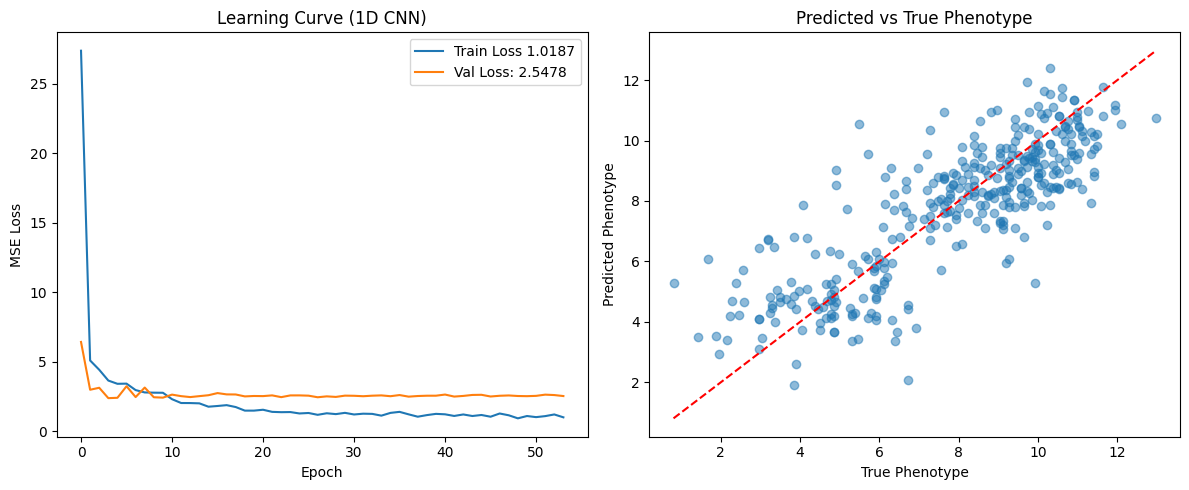

In [11]:
for repeat in range(5):   
    train_loader, val_loader, test_loader,input_dim = get_SNP("merged_data.csv")
    model, criterion, optimizer = createCNNmodel(blocks=[16,32],hidden_units=[16,32], drop=0.2,lr=1e-2,decay=1e-5, lin_activation_type="relu",con_activation_type="tanh",optimizer_type="adam",init_weights=False,batch=True)
    trained_model,train_losses,val_losses = trainAndEval(model,criterion,optimizer,max_epochs=150,patience=50)
    y_pred,y_true,mse,mae,r2 = performance_metrics(trained_model,test_loader)

    print("\n=== Final Evaluation on Test Set ===")
    print(f"MSE:  {mse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R^2:  {r2:.4f}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label=f'Train Loss {train_losses[-1]:.4f}')
    plt.plot(val_losses, label=f'Val Loss: {val_losses[-1]:.4f}')
    plt.title("Learning Curve (1D CNN)")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.scatter(y_true, y_pred, alpha=0.5)
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.title("Predicted vs True Phenotype")
    plt.xlabel("True Phenotype")
    plt.ylabel("Predicted Phenotype")

    plt.tight_layout()
    plt.show()
    break



In [12]:
pd.read_csv("Results/combined_output_previous_study.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'Results/combined_output_previous_study.csv'

In [ ]:
def importance_graph(model, data, snp_number=20):
    N = snp_number
    
    df = pd.read_csv(f"dataset/{data}")
    X = df.drop(["Breeding line","population","Yield"], axis=1)
    
    # Modified for CNN - access the first conv layer weights
    first_conv_weights = model.cnn_layers["input"].weight
    
    # Average across filters (out_channels dimension)
    snp_weights = first_conv_weights.squeeze().mean(dim=0).detach().cpu().numpy()
    
    fig_height = max(5, N * 0.4)
    plt.figure(figsize=(12, fig_height))

    snp_names = np.array(X.columns)
    sorted_indices = np.argsort(snp_weights)

    plt.barh(snp_names[sorted_indices][-N:], snp_weights[sorted_indices][-N:], color="forestgreen", label="Positive Effect")
    plt.barh(snp_names[sorted_indices][:N], snp_weights[sorted_indices][:N], color="firebrick", label="Negative Effect")

    plt.xlabel("Feature Importance (Weight Value)")
    plt.ylabel("SNPs")
    plt.title(f"Top SNPs Affecting Phenotype for {data}")
    plt.gca().invert_yaxis()
    plt.legend()
    plt.savefig(f"important_{snp_number}_snps for {data}.png", dpi=300)
